## Unit 3 Capstone
In this notebook, I am going to try and predict which kids in a portugese school will need extra help in order to improve their scores 

In [387]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from catboost import Pool, CatBoostClassifier, cv, CatboostIpythonWidget
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from matplotlib.mlab import PCA as mlabPCA

In [529]:
#lets load the data
df = pd.read_csv(r'C:\Users\jmfra\OneDrive\Documents\Thinkful Data Science Files\3 capstone data\student-por.csv')

In [530]:
#at first look the file has a few extra columns that python will hide so lets lengthen the display
pd.options.display.max_columns = 999

In [531]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


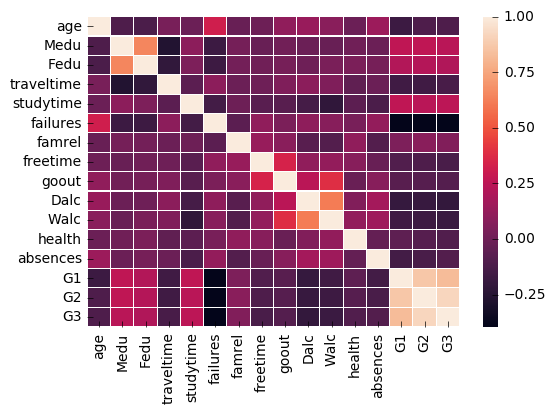

In [532]:
#lets check the already continous variables to see if there are any correlations
sns.heatmap(df.corr(), linewidths=.1)
plt.show()

In [533]:
#number of days during the week and weekend a kid drinks are very directly related so lets combine them and make it total
#number of days during the week
df['Walc'] = df['Walc'] + df['Dalc']
df = df.drop('Dalc',1)

In [534]:
#our independent variables are grades in 3 periods. they all have colors implying almost a 100% correlation so lets redefine
#them by averaging them into one overall score
df['AvgG'] = (df['G1'] + df['G2'] + df['G3']) / 3
df = df.drop(['G1', 'G2', 'G3'],1)
df.AvgG.describe()

count    649.000000
mean      11.625064
std        2.833360
min        1.333333
25%       10.000000
50%       11.666667
75%       13.333333
max       18.666667
Name: AvgG, dtype: float64

In [535]:
#from the meta data, Fedu and Medu deccribe the education level of each of a childs parents. We would expect the highest level of
#education in the family to be more important to a childs likelyhood of failing courses than each indicidual. lets create a knew
#column that contains the highest higher value from the two columns and then delete the originals
df['Famedu'] = np.where(df['Medu'] >= df['Fedu'], df['Medu'], df['Fedu'])
df = df.drop(['Medu', 'Fedu'], 1)

In [536]:
df['Mjob'].groupby(df['Pstatus']).count()

Pstatus
A     80
T    569
Name: Mjob, dtype: int64

In [537]:
df['Mjob'].groupby(df['guardian']).count()

guardian
father    153
mother    455
other      41
Name: Mjob, dtype: int64

In [538]:
#the only remaining column that sticks out is guardian. It lists the guardian of the parent as mother father or other. My issue
#with this column is that even when the parents are not split up (another column) someone is still listed implying its arbitrary
#for a lot of the entries since 569 of the 649 entries are still together. It might be an important piece of information for some
#of these, but we do not have enough information to know which entries are important
df = df.drop('guardian',1) 

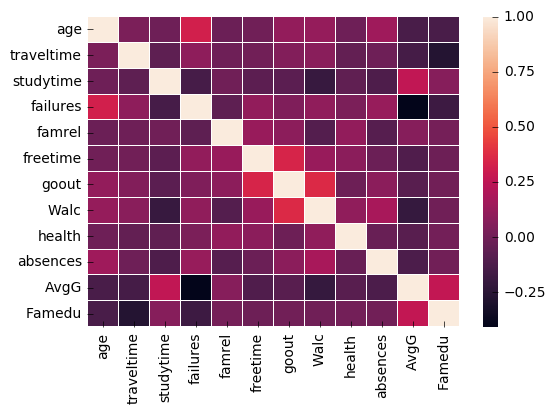

In [539]:
sns.heatmap(df.corr(), linewidths=.1)
plt.show()

In [540]:
#Now lets take all of the categorical varaibles with 2 inputs and transfer them into booleans to make them easy to work with
boolist = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 
           'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
           'romantic']
for x in boolist:
    df[x] = pd.get_dummies(df[x])
df.head()

,school,sex,age,address,famsize,Pstatus,Mjob,Fjob,reason,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Walc,health,absences,AvgG,Famedu
0,1.0,1.0,18,0.0,1.0,1.0,at_home,teacher,course,2,2,0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,4,2,3,4,7.333333,4
1,1.0,1.0,17,0.0,1.0,0.0,at_home,other,course,1,2,0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5,3,3,2,3,2,10.333333,1
2,1.0,1.0,15,0.0,0.0,0.0,at_home,other,other,1,2,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4,3,2,5,3,6,12.333333,1
3,1.0,1.0,15,0.0,1.0,0.0,health,services,home,1,3,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,2,2,2,5,0,14.000000,4
4,1.0,1.0,16,0.0,1.0,0.0,other,other,home,1,2,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,2,3,5,0,12.333333,3


In [541]:
#before we continue, getting dummies is the best way to handle categorical variables with more than 2 inputs, however there 
#might be an issue with having too many features since we do not even have 600 inputs so I am going to copy the data so we 
#can test both
df_labelencode = df.copy()

In [542]:
#lets create columns for each input in the remaining categorical variables
l2 =['Mjob', 'Fjob', 'reason']
for x in l2:
    df = pd.concat([df, pd.get_dummies(df[x])], axis=1)
    df = df.drop(x,1)

In [543]:
df.head()

,school,sex,age,address,famsize,Pstatus,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Walc,health,absences,AvgG,Famedu,at_home,health,other,services,teacher,at_home,health,other,services,teacher,course,home,other,reputation
0,1.0,1.0,18,0.0,1.0,1.0,2,2,0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,4,2,3,4,7.333333,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,17,0.0,1.0,0.0,1,2,0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5,3,3,2,3,2,10.333333,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,15,0.0,0.0,0.0,1,2,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4,3,2,5,3,6,12.333333,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,15,0.0,1.0,0.0,1,3,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,2,2,2,5,0,14.000000,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,16,0.0,1.0,0.0,1,2,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,2,3,5,0,12.333333,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [544]:
df = df.astype('int64')

In [545]:
#Now lets check a bunch of different regressors to see which one preforms the best on this data. I am going to add the train and
#test scores for the same groupings for each test into a dataset to easily compare them
X = df.drop('AvgG',1)
y = df.AvgG

In [546]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
rfc = ensemble.RandomForestRegressor()
rfc.fit(X_train,y_train)
rfc_train = rfc.score(X_train,y_train)
rfc_test = rfc.score(X_test,y_test)

In [547]:
gbc = ensemble.GradientBoostingRegressor()
gbc.fit(X_train,y_train)
gbc_train = gbc.score(X_train,y_train)
gbc_test = gbc.score(X_test,y_test)

In [548]:
svr = svm.SVR()
svr.fit(X_train,y_train)
svr_train = svr.score(X_train,y_train)
svr_test = svr.score(X_test,y_test)

In [549]:
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
knn_train = knn.score(X_train,y_train)
knn_test = knn.score(X_test,y_test)

In [550]:
lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test = lr.score(X_test,y_test)

In [551]:
scores = pd.DataFrame()
scores['train_score'] = [rfc_train, gbc_train, svr_train, knn_train, lr_train]
scores['test_scoret_score'] = [rfc_test, gbc_test, svr_test, knn_test, lr_test]
scores.index = ['random forest', 'gradient boost', 'svr', 'knn', 'linear']
scores

,train_score,test_scoret_score
random forest,0.878941,0.237726
gradient boost,0.774130,0.297748
svr,0.412718,0.236377
knn,0.393848,0.069560
linear,0.428749,0.284749


In [552]:
#lets go ahead and try the same thing with label encoded variables like we discussed earlier to see if this improves anything
l2 =['age', 'Mjob', 'Fjob', 'reason']
for x in l2:
    le = preprocessing.LabelEncoder()
    le.fit(df_labelencode[x])
    df_labelencode[x] = le.transform(df_labelencode[x])
df_labelencode.head()

,school,sex,age,address,famsize,Pstatus,Mjob,Fjob,reason,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Walc,health,absences,AvgG,Famedu
0,1.0,1.0,3,0.0,1.0,1.0,0,4,0,2,2,0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,4,2,3,4,7.333333,4
1,1.0,1.0,2,0.0,1.0,0.0,0,2,0,1,2,0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,5,3,3,2,3,2,10.333333,1
2,1.0,1.0,0,0.0,0.0,0.0,0,2,2,1,2,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4,3,2,5,3,6,12.333333,1
3,1.0,1.0,0,0.0,1.0,0.0,1,3,1,1,3,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,2,2,2,5,0,14.000000,4
4,1.0,1.0,1,0.0,1.0,0.0,2,2,1,1,2,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4,3,2,3,5,0,12.333333,3


In [553]:
X = df_labelencode.drop('AvgG',1)
y = df_labelencode.AvgG

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

rfc = ensemble.RandomForestRegressor()
rfc.fit(X_train,y_train)
rfc_train = rfc.score(X_train,y_train)
rfc_test = rfc.score(X_test,y_test)

gbc = ensemble.GradientBoostingRegressor()
gbc.fit(X_train,y_train)
gbc_train = gbc.score(X_train,y_train)
gbc_test = gbc.score(X_test,y_test)

svr = svm.SVR()
svr.fit(X_train,y_train)
svr_train = svr.score(X_train,y_train)
svr_test = svr.score(X_test,y_test)

knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
knn_train = knn.score(X_train,y_train)
knn_test = knn.score(X_test,y_test)

lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test = lr.score(X_test,y_test)

scores = pd.DataFrame()
scores['train_score'] = [rfc_train, gbc_train, svr_train, knn_train, lr_train]
scores['test_score'] = [rfc_test, gbc_test, svr_test, knn_test, lr_test]
scores.index = ['random forest', 'gradient boost', 'svr', 'knn', 'linear']
scores

,train_score,test_score
random forest,0.877692,0.276354
gradient boost,0.772878,0.310519
svr,0.456423,0.236806
knn,0.392973,0.092396
linear,0.396572,0.304401


In [554]:
#these tests all show a clear pattern: the train set are overfitting the data way too much and we have to solve this
#in order to use this data we will likely have to turn the dependent varaible into a categorical variable instead of 
#a continuous one. There are a few different options here. We are going to try two and see which one improves performance
#more. We are going to seperate the kids into people who are likely to fail or pass and we are going to seperate kids
#who are exceptional, average, and under-performing. lets make another copy of the data set to try that first
df = df_labelencode.copy()
df1 = df_labelencode.copy()
df2 = df_labelencode.copy()

In [555]:
#according to https://www.classbase.com/countries/Portugal/Grading-System, anything 10 or above is passing and anything 16 or 
#above is considered honors. Lets define those at the cut offs for the scale and see if the data roughly evenly distributed 
#where 0 is honors, 1 is average and 2 is failures
df1['AvgG'] = np.where(df1['AvgG'] >= 16, 0, df1['AvgG'])
df1['AvgG'] = np.where(df1['AvgG'] >= 10, 1, df1['AvgG'])
df1['AvgG'] = np.where(df1['AvgG'] > 1, 2, df1['AvgG'])
df1['AvgG'].groupby(df1['AvgG']).count()

AvgG
0.0     47
1.0    445
2.0    157
Name: AvgG, dtype: int64

In [556]:
#looks like there are too many average students and not enough with honors. Lets lower the cutoff a little until the groups 
#are closer
df2['AvgG'] = np.where(df2['AvgG'] >= 13, 0, df2['AvgG'])
df2['AvgG'] = np.where(df2['AvgG'] >= 10, 1, df2['AvgG'])
df2['AvgG'] = np.where(df2['AvgG'] > 1, 2, df2['AvgG'])
df2['AvgG'].groupby(df2['AvgG']).count()

AvgG
0.0    213
1.0    279
2.0    157
Name: AvgG, dtype: int64

In [557]:
X = df2.drop('AvgG', 1)
y = df2.AvgG

In [558]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [559]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
print(rfc.score(X_train,y_train))
rfc.score(X_test,y_test)

0.987654320988


0.47384615384615386

In [560]:
#This massivley improved the model from .86 to .98 and improved the train score from .20 to .53. Lets see if seperating the 
#group by failing and passing as well
df['AvgG'] = np.where(df['AvgG'] >= 10, 1, 0)

In [561]:
df['AvgG'].groupby(df['AvgG']).count()

AvgG
0    157
1    492
Name: AvgG, dtype: int64

In [562]:
#at first look, the 2 groups are not very even. Lets do the test and check error types to see if it improves the model
X1 = df.drop('AvgG', 1)
y1 = df.AvgG
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.5, random_state=0)
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train1,y_train1)
print(rfc.score(X_train1,y_train1))
rfc.score(X_test1,y_test1)

0.993827160494


0.75384615384615383

In [563]:
pred_y = rfc.predict(X_test1)
crosstab = pd.crosstab(pred_y, y_test1)
print('Actual on top and predicted on left')
print(crosstab)
print('accurately predicted kids who failed')
print(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
print('accurately predicted kids who passed')
print(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))

Actual on top and predicted on left
AvgG    0    1
row_0         
0      30   30
1      50  215
accurately predicted kids who failed
0.375
accurately predicted kids who passed
0.877551020408


In [564]:
#as expected, the model  accurately predicts kids that pass, but does not accurately predict the kids who will fail.
#lets try to even out the groups by dropping some of the kids who passed to make the group even
number_of_fails = len(df[df.AvgG == 0])
fail_indices = np.array(df[df.AvgG == 0].index)
pass_indices = df[df.AvgG == 1].index
random_pass_indices = np.array(np.random.choice(pass_indices, number_of_fails, replace = False))
new_indices = np.concatenate([fail_indices,random_pass_indices])
data = df.iloc[new_indices,:]
X = data.drop('AvgG', 1)
y = data.AvgG

In [565]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
print(rfc.score(X_train,y_train))
rfc.score(X_test,y_test)

0.987261146497


0.68152866242038213

In [566]:
pred_y = rfc.predict(X_test)
crosstab = pd.crosstab(pred_y, y_test)
print('Actual on top and predicted on left')
print(crosstab)
print('accurately predicted kids who failed')
print(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
print('accurately predicted kids who passed')
print(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))

Actual on top and predicted on left
AvgG    0   1
row_0        
0      54  24
1      26  53
accurately predicted kids who failed
0.675
accurately predicted kids who passed
0.688311688312


In [567]:
pred_y = rfc.predict(X1)
crosstab = pd.crosstab(pred_y, y1)
print('Actual on top and predicted on left')
print(crosstab)
print('accurately predicted kids who failed')
print(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
print('accurately predicted kids who passed')
print(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))
print('entire set score')
print(rfc.score(X1,y1))

Actual on top and predicted on left
AvgG     0    1
row_0          
0      131  132
1       26  360
accurately predicted kids who failed
0.834394904459
accurately predicted kids who passed
0.731707317073
entire set score
0.75654853621


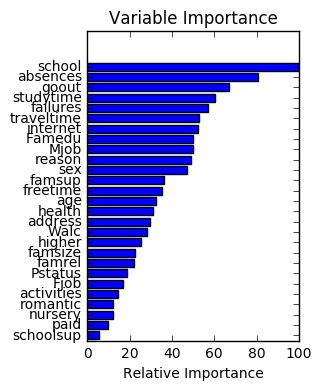

In [568]:
#lets check and plot the feature importance
feature_importance = rfc.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [569]:
#lets try PCA on some of the least important features to try and improve the model
unimp = data[['romantic', 'sex', 'internet', 'address', 'paid', 
                        'schoolsup', 'Pstatus', 'nursery', 'famsup', 'age']]
pca = PCA(n_components=1)
pca.fit(unimp)
data['PCA'] = pca.transform(unimp)
data = data.drop(['romantic', 'sex', 'internet', 'address', 
                                      'paid', 'schoolsup', 'Pstatus', 'nursery', 
                                      'famsup', 'famsize'],1)

C:\Users\jmfra\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [570]:
data.head()

,school,age,Mjob,Fjob,reason,traveltime,studytime,failures,activities,higher,famrel,freetime,goout,Walc,health,absences,AvgG,Famedu,PCA
0,1.0,3,0,4,0,2,2,0,1.0,0.0,4,3,4,2,3,4,0,4,1.110956
18,1.0,2,3,3,0,1,1,3,0.0,0.0,5,5,5,6,5,2,0,3,0.097456
43,1.0,0,3,3,0,1,1,0,1.0,0.0,5,4,1,2,1,0,0,2,-1.930028
52,1.0,0,1,1,2,2,1,0,1.0,0.0,5,5,5,7,5,4,0,4,-1.842525
67,1.0,1,3,2,0,1,4,0,1.0,0.0,4,3,3,3,5,0,0,3,-0.927364


In [571]:
data = data.astype('int64')

In [572]:
X = data.drop('AvgG',1)
y = data.AvgG
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)
print(rfc.score(X_train,y_train))
rfc.score(X_test,y_test)

0.974522292994


0.72611464968152861

In [573]:
pred_y = rfc.predict(X)
crosstab = pd.crosstab(pred_y, y)
print('Actual on top and predicted on left')
print(crosstab)
print('accurately predicted kids who failed')
print(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
print('accurately predicted kids who passed')
print(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))
print('entire set score')
print(rfc.score(X,y))

Actual on top and predicted on left
AvgG     0    1
row_0          
0      137   27
1       20  130
accurately predicted kids who failed
0.872611464968
accurately predicted kids who passed
0.828025477707
entire set score
0.850318471338


After all the changes made in this notebook it is obvious that the model will always overfit the training set that we give it. I could not get a consistent test set score above .8 and could only improve the most important variable to around .75. The data was only collected over 1 year with one input for each individual student and without more rows, it is very unlikely the model will ever improve. 

I think this project could be massively improved by taking data over a wider range of schools (this set only included 2) and over a few years. 